# Deep Homography Net

In [2]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3184007216431629236
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3433345024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8338772392718503246
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Data Wrangling

Read the directory

In [6]:
from os import path

train_split = 0.8
valid_split = 0.2

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = path.join(data_dir, 'hnet_training')
all_files = pd.read_csv(path.join(original_data_dir, 'homographies.tsv'), sep='\t')
all_files.head()

,Unnamed: 0,fname,h
0,0,Tp26_Y000_X000_040_0000,"-27,-16,-15,-5,-30,-25,-4,26"
1,1,Tp26_Y000_X000_040_0001,"0,-24,-8,7,-26,18,-13,-6"
2,2,Tp26_Y000_X000_040_0002,"-18,-2,21,-8,13,26,25,4"
3,3,Tp26_Y000_X000_040_0003,"25,-9,-30,-5,-6,18,-19,-6"
4,4,Tp26_Y000_X000_040_0004,"-8,4,-10,9,-13,2,-32,-23"


In [12]:
all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac].values.tolist()
    valid_paths = all_files[frac:].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    48000
Validation images: 12000


## HomographyNet

Regression variant

> We use 8 convolutional layers with a max pooling layer (2x2, stride 2) after every two convolutions. The 8 convolutional layers have the following number of filters per layer: 64 [x4], 128 [x4]. The convolutional layers are followed by two fully connected layers. The first fully connected layer has 1024 units. Dropout with a probability of 0.5 is applied after the final convolutional layer and the first fully-connected layer.

> The regression network directly produces 8 real-valued
numbers and uses the Euclidean (L2) loss as the final layer
during training.

> using stochastic gradient descent (SGD) with momentum of 0.9. We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.

In [84]:
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Dense, Flatten, MaxPooling2D, Input, Activation, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K

def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def conv_block(m, filters):
    kernel = (3, 3)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    m = BatchNormalization()(m)
    return MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(m)

def homography_regression_model(input_dims):
    input_shape=(*input_dims, 2)
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # 4x 64
    x = conv_block(input_layer, 64)
    x = conv_block(x,           64) 
    # 4x 128
    x = conv_block(x,           128)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, name='FC_1024')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(8, name='output')(x)
    
    return Model(inputs=input_layer, outputs=[out])

In [85]:
from keras.optimizers import SGD

img_size = (128, 128)

# opt = SGD(lr=0.005, momentum=0.9, decay=0.0015)
opt = SGD(lr=0.005, momentum=0.9)

my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 128, 128, 2)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 128, 128, 64)      1216      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 64)        36928     
__________

## Data Generators

We generate the "seemingly infinite training data" on the fly by using Keras' DataGenerators.

In [87]:
import math
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import rotate

def h_string_to_arr(s):
    return np.array(list(map(lambda x: np.float32(x), row['h'].split(','))))


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size, train_dir):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size
        self.train_dir = train_dir

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def read_images(self, fname):
        ext = '.tif'
        base = path.join(self.train_dir, fname)
        a = img_to_array(load_img(base + '_A' + ext, grayscale=True))
        b = img_to_array(load_img(base + '_B' + ext, grayscale=True))
        return np.dstack((a,b))
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 2))
        y = np.zeros(shape=(batch_size, 8))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,row in enumerate(batch):
            fname, h_str = row[1:]
            X[j] = self.read_images(fname)
            y[j] = h_string_to_arr(h_str)
        return (X, y)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

tmp directory already exists


## Training

> The networks are trained for for 90,000 total iterations using a batch size of 64.


In [88]:
batch_size = 64
total_iterations = 90000

steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

epochs = int(total_iterations / steps_per_epoch)

training_generator   = DataGenerator(train_paths, batch_size, img_size, original_data_dir)
validation_generator = DataGenerator(valid_paths, batch_size, img_size, original_data_dir)

# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('tmp/weights-%d-%d.hdf5' % 
                                         (batch_size, img_size[0])), 
                               verbose=1, save_best_only=True)

print('Epochs:            %d' % epochs)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Epochs:            120
Traning images:    48000
Validation images: 12000
Training steps:    750
Validation steps:  187


In [89]:
hist = my_model.fit_generator(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              workers=3,
                              verbose=2,
                              callbacks=[history, checkpointer, early_stopping]
                             )

Epoch 1/120
 - 292s - loss: 2.4342 - val_loss: 0.4624

Epoch 00001: val_loss improved from inf to 0.46237, saving model to tmp/weights-64-128.hdf5
Epoch 2/120
 - 289s - loss: 1.1649 - val_loss: 1.2239

Epoch 00002: val_loss did not improve from 0.46237
Epoch 3/120
 - 289s - loss: 1.1037 - val_loss: 1.3588

Epoch 00003: val_loss did not improve from 0.46237
Epoch 4/120
 - 290s - loss: 1.2258 - val_loss: 1.0010

Epoch 00004: val_loss did not improve from 0.46237
Epoch 5/120
 - 291s - loss: 1.0629 - val_loss: 0.2677

Epoch 00005: val_loss improved from 0.46237 to 0.26769, saving model to tmp/weights-64-128.hdf5
Epoch 6/120
 - 293s - loss: 1.0745 - val_loss: 0.8044

Epoch 00006: val_loss did not improve from 0.26769
Epoch 7/120
 - 293s - loss: 1.0464 - val_loss: 0.6133

Epoch 00007: val_loss did not improve from 0.26769
Epoch 8/120
 - 296s - loss: 1.0221 - val_loss: 0.2711

Epoch 00008: val_loss did not improve from 0.26769
Epoch 9/120
 - 293s - loss: 0.9173 - val_loss: 0.4661

Epoch 00009

## Results inspection

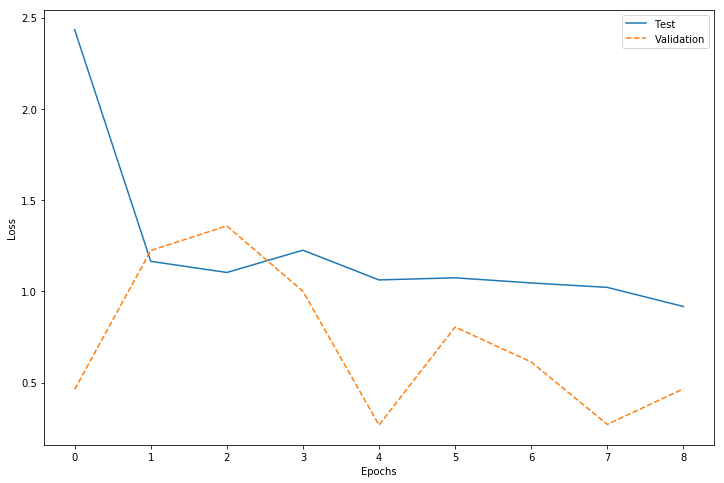

In [90]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
import cv2
from numpy.random import 
from skimage.transform import resize

def show_registration(ref, mov):
    fig, (a, b) = plt.subplots(1, 2, figsize=(5, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    plt.show()

def alter_pt(pt, r):
    return (pt[0] + randint(-r,r), pt[1] + randint(-r,r))

def create_patch(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape)
        B = full_warped[y:y+size,x:x+size]
        if A.shape == B.shape:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])
    
test_dir = r'../data/learning'
im1 = imread(test_dir + '/Tp26_Y000_X001_040.tif')
p_a, p_b, Hab = create_patch(im1, 128, 32)
test_im = np.dstack((p_a, p_b))
test_im = test_im.reshape(1, *test_im.shape)
H = my_model.predict(test_im)
print(H.reshape(4,2))
show_registration(im1, im2)

NameError: name 'randint' is not defined